# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import warnings
warnings.filterwarnings("ignore")

# change the default style of plots
import matplotlib.style as style
style.use('dark_background')

pd.options.display.max_columns = 250
pd.set_option('display.max_rows', None)

import statsmodels.api as sm
from scipy import stats

In [2]:
df = pd.read_csv('hotel_cleaned.csv')

# Multivariate Analysis

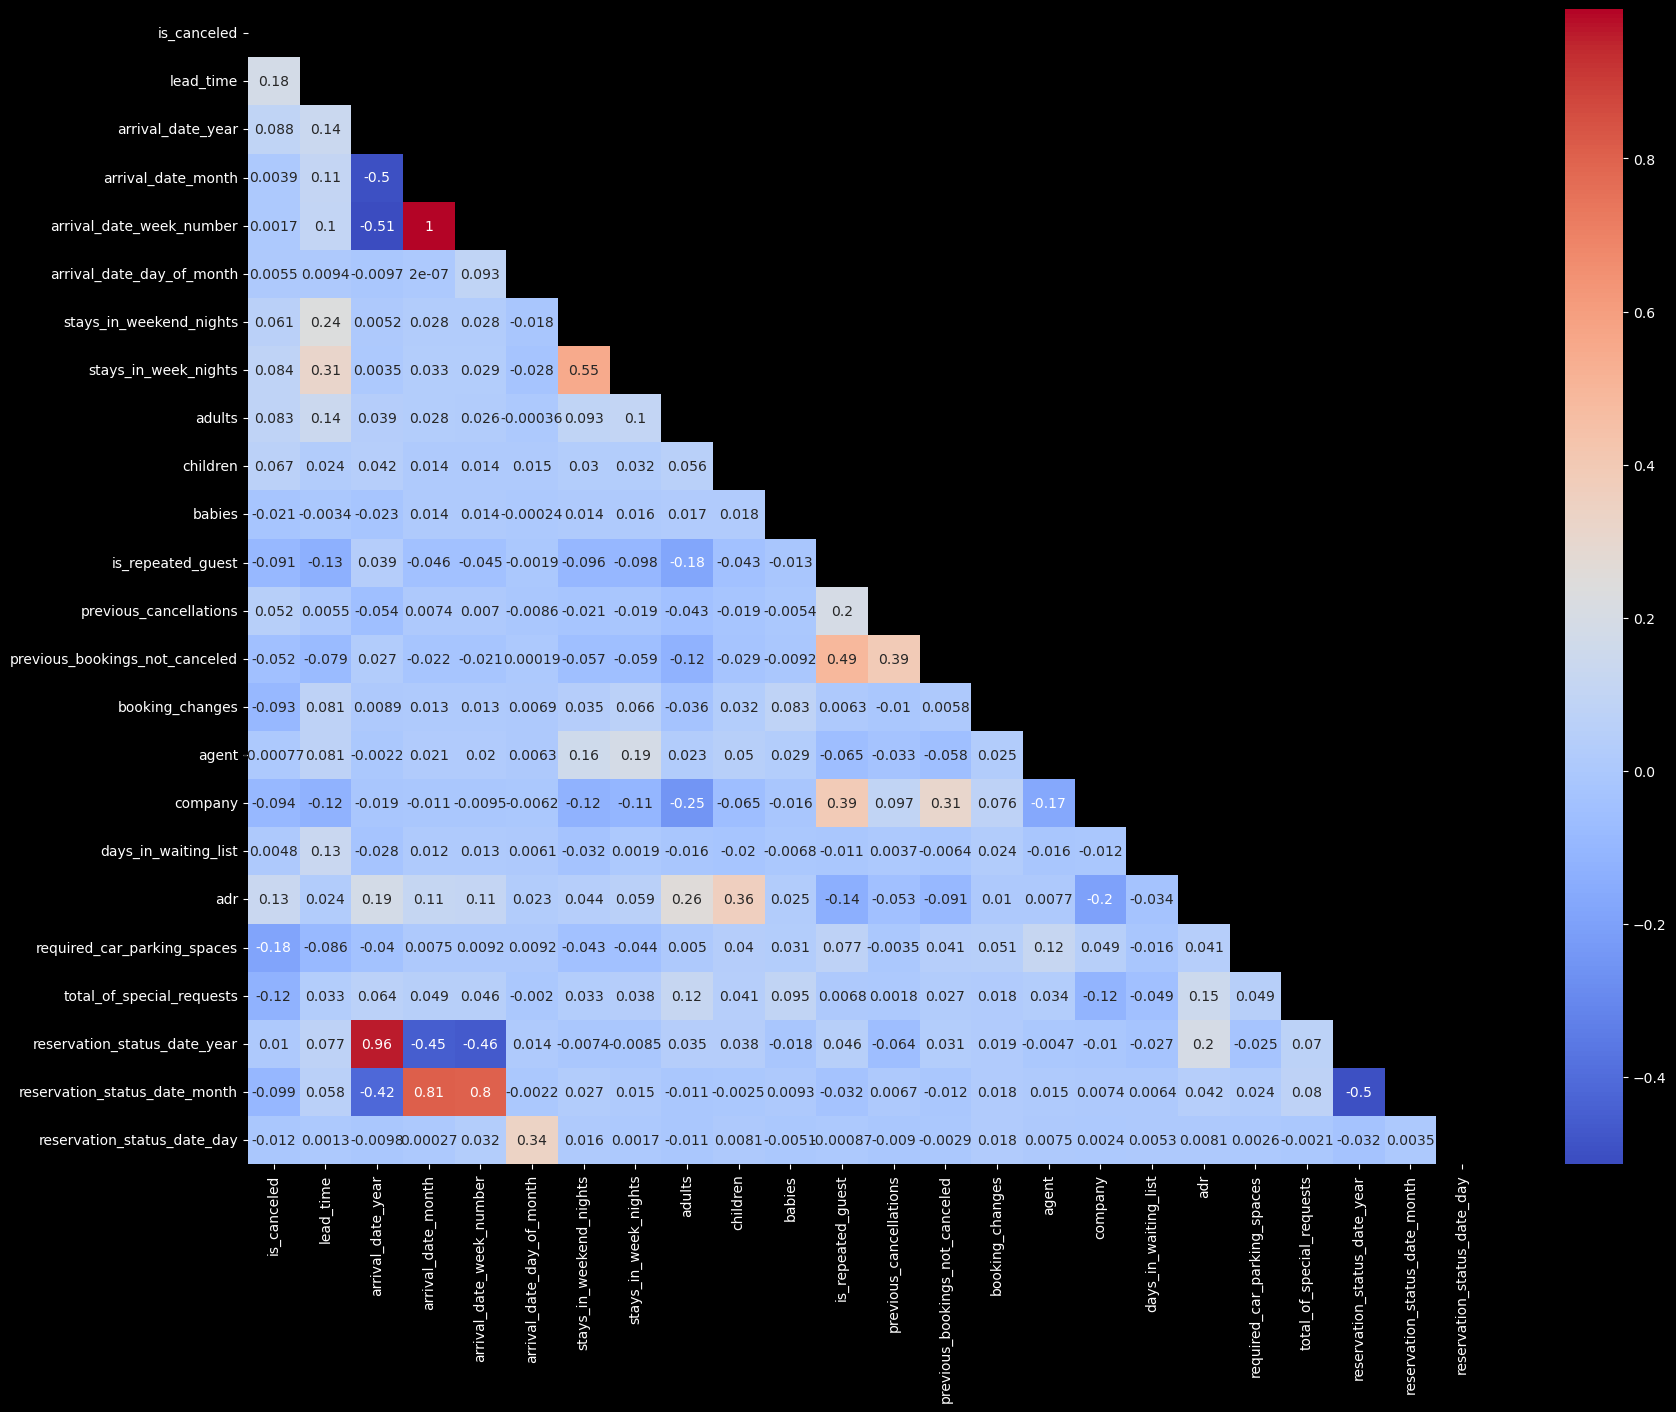

In [3]:
# plt.figure(figsize=(20,15))
plt.figure(figsize=(20,15))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm')
plt.show()

Features with multicollinearity:
- `arrival_date_week_number` and `arrival_date_month`
- `reservation_status_date_year` and `arrival_date_yeear`
- `reservation_status_date_month` and `arrival_date_month`, `arrival_date_week_number`

I am dropping `reservation_status`, and the date related with it, because they are recorded after a booking is either canceled or confirmed. This attribute highly affects the target (meaning when `reservation_status` = 'Canceled', y = 1). Consequently, the date of reservation status is unknow until the guest cancel or check out of the hotel. This will lead to data leakage in our models, I will remove all three attributes related to reservation status and corresponding dates.

I am also dropping `arrival_date_week_number` because the data already has strong monthly patterns like we saw in the previous EDA, also months capture seasonal patterns which are easier to interpret than week. Therefore, I will keep arrival month and remove the week number column.

In [4]:
# list of columns to drop
drop_cols = ['arrival_date_week_number','reservation_status','reservation_status_date_year','reservation_status_date_month','reservation_status_date_day']

In [5]:
# drop correlated columns
df = df.drop(columns=drop_cols)

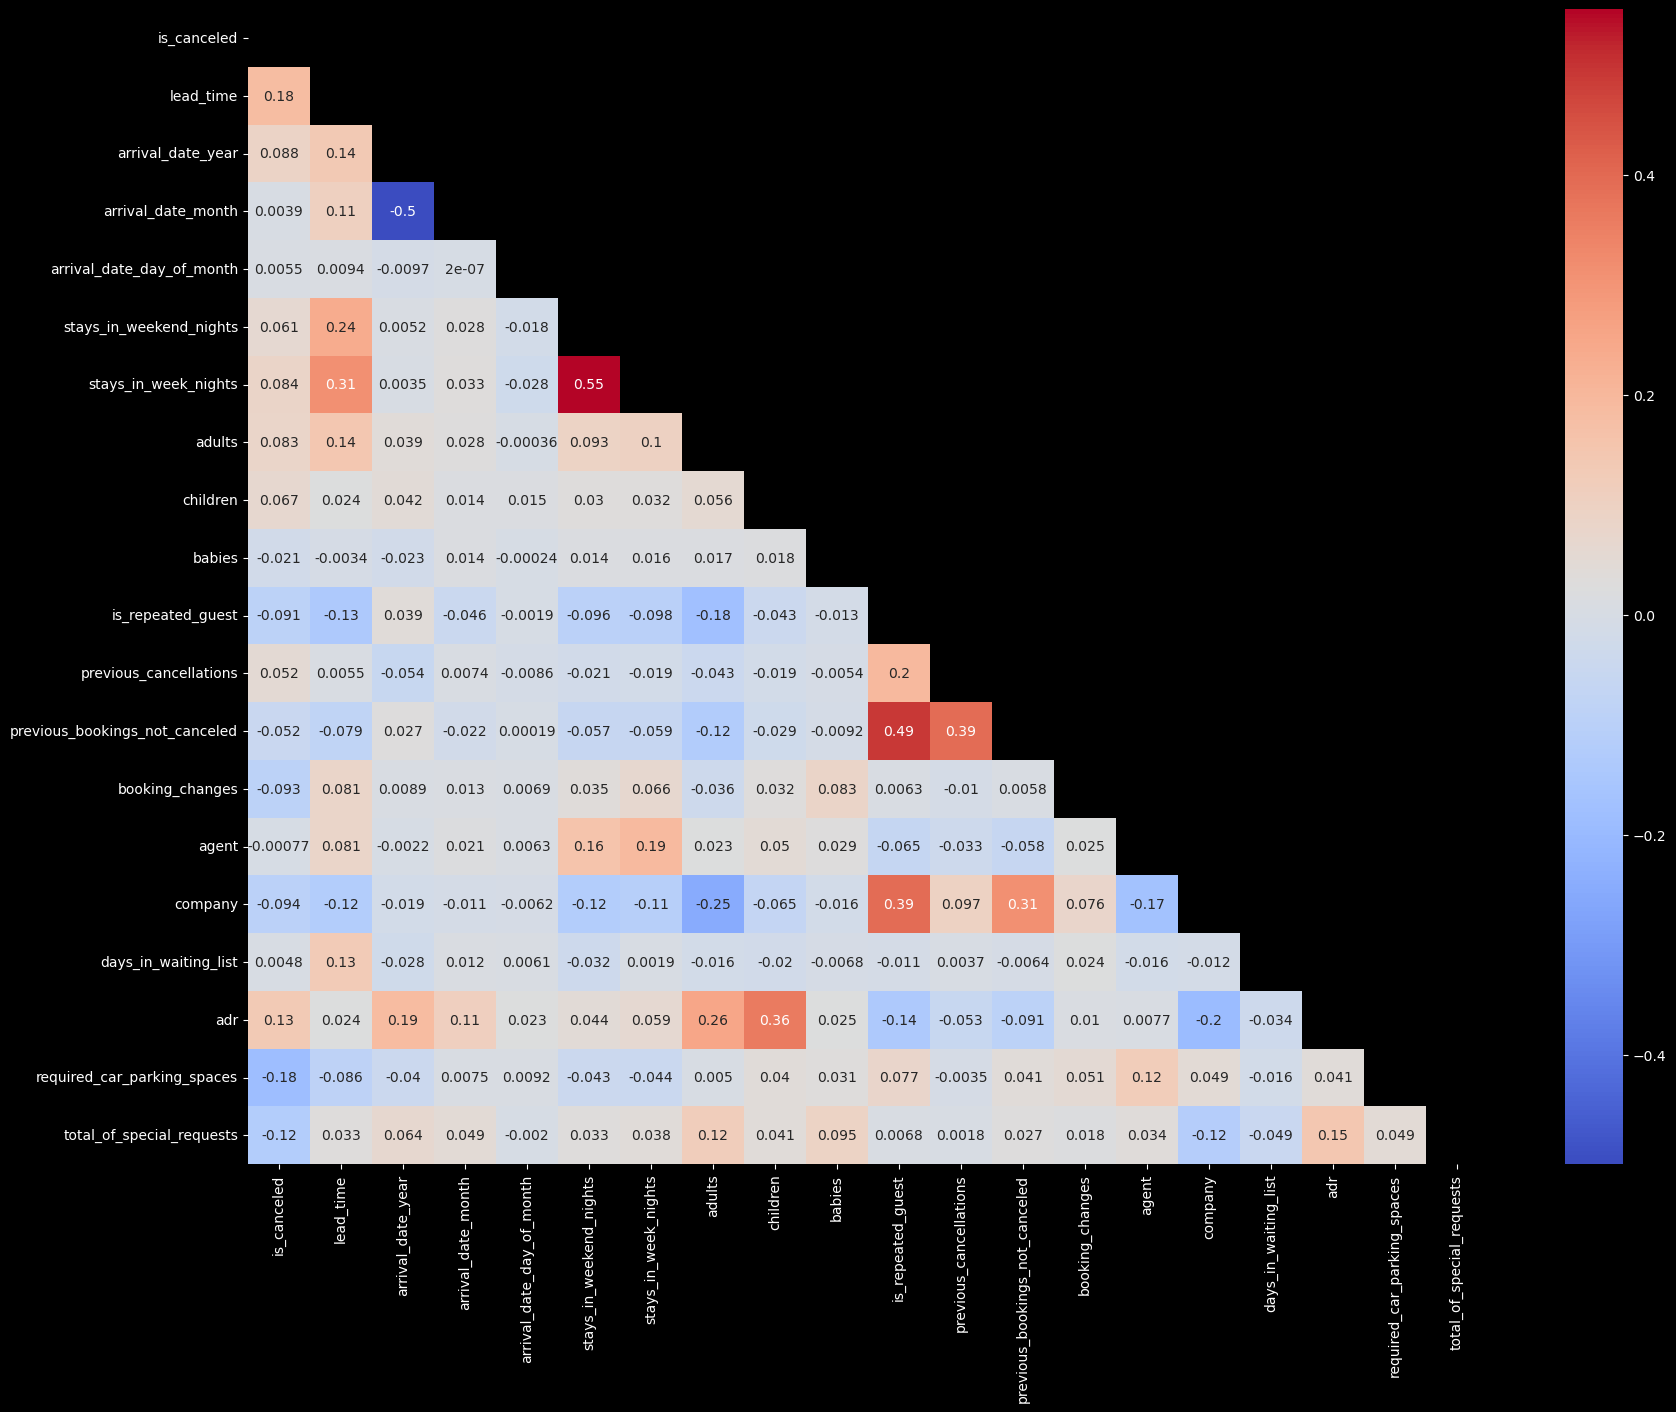

In [6]:
# check correlation again
plt.figure(figsize=(20,15))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm')
plt.show()

In [7]:
# check correlation between independent variables and target variable
target_corr = df.corr()['is_canceled']
target_corr.abs().sort_values(ascending=False)

is_canceled                       1.000000
required_car_parking_spaces       0.184571
lead_time                         0.184262
adr                               0.133130
total_of_special_requests         0.121078
company                           0.094345
booking_changes                   0.093199
is_repeated_guest                 0.091422
arrival_date_year                 0.087995
stays_in_week_nights              0.084065
adults                            0.082966
children                          0.066535
stays_in_weekend_nights           0.061102
previous_bookings_not_canceled    0.052189
previous_cancellations            0.051529
babies                            0.020674
arrival_date_day_of_month         0.005510
days_in_waiting_list              0.004758
arrival_date_month                0.003927
agent                             0.000769
Name: is_canceled, dtype: float64

- `lead_time`, `total_of_special_requests`, `required_car_parking_spaces`, `adr` are the most relevant numeric features
- `arrival_date_day_of_month`, `arrival_date_month`, `days_in_waiting_list`, `agent` are the least relevant numeric features

# Hypothesis Testing

## Categorical Features

For categorical features I am using chi-squared test to examine whether each of the categorical features has some relationship with `is_canceled`. Let's make our hypotheses for chi-squared testing:
- $H_0$: There is no relationship betweeen the categorical feature and the target feature (is_canceled).
- $H_1$: There is some relationships betweeen the categorical feature and the target feature.

In [8]:
# get the list of categorical features
categorical_features = df.select_dtypes('object').columns.tolist()

# recall agent column contains data of each agent's code, there is no ordinal order, it should be treated as categorical feature
categorical_features.append('agent')

In [9]:
for i in categorical_features:
    
    # create contigency tables
    chi2 = stats.chi2_contingency(pd.crosstab(df['is_canceled'],df[i])) 
                                  
    # get p-values
    p_value = chi2[1]


    print(f"p-value for `is_canceled` and {i} is: {round(p_value,4)}\n")
    print(f"significant? {p_value<0.05}")
    print('='*40)

p-value for `is_canceled` and hotel is: 0.0

significant? True
p-value for `is_canceled` and meal is: 0.0

significant? True
p-value for `is_canceled` and country is: 0.0

significant? True
p-value for `is_canceled` and market_segment is: 0.0

significant? True
p-value for `is_canceled` and distribution_channel is: 0.0

significant? True
p-value for `is_canceled` and reserved_room_type is: 0.0

significant? True
p-value for `is_canceled` and assigned_room_type is: 0.0

significant? True
p-value for `is_canceled` and deposit_type is: 0.0

significant? True
p-value for `is_canceled` and customer_type is: 0.0

significant? True
p-value for `is_canceled` and agent is: 0.0

significant? True


P-values of the chi-sqaured tests for all the categorical features are well below 0.05 threshold. Thus we reject the null hypothesis, and conclude that they all have some relationships with booking cancellation.

## Numeric Features

For numeric features, I am going to use unpaired two-sample t-test to examine if the distribution differs between confirmed bookings and canceled ones. Let's make our hypotheses:
- $H_0$: The distiributions of the numeric feature are the same between confirmed and canceled bookings.
- $H_1$: The distiributions of the numeric feature are the different between confirmed and canceled bookings.

In [10]:
# get the list of numeric features
numeric_features = df.drop(columns='is_canceled').select_dtypes('number').columns.tolist()

# exclude 'agent' column
numeric_features.remove('agent')

numeric_features

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

Note that, since the size of the data is quite large, I might treat the date features as numeric features. This could be computionally efficient and can provide sufficient statistical power.

In [11]:
# assign numeric features based on two groups of `is_canceled` 
canceled_bookings = df[df['is_canceled']==1]
confirmed_bookings = df[df['is_canceled']==0]

In [12]:
for i in numeric_features:
    
    # get p-values
    p_value = stats.ttest_ind(canceled_bookings[i],confirmed_bookings[i])[1]
    
    print(f"p-value for {i} is: {p_value}\n")
    print(f"Significant? {p_value<0.05}\n")
    print('='*40)

p-value for lead_time is: 0.0

Significant? True

p-value for arrival_date_year is: 4.202228729361973e-149

Significant? True

p-value for arrival_date_month is: 0.2467654270970174

Significant? False

p-value for arrival_date_day_of_month is: 0.10407644778521438

Significant? False

p-value for stays_in_weekend_nights is: 9.469782081094056e-73

Significant? True

p-value for stays_in_week_nights is: 3.2798615875508323e-136

Significant? True

p-value for adults is: 1.0277794009435176e-132

Significant? True

p-value for children is: 6.072122544827671e-86

Significant? True

p-value for babies is: 1.0691884095485877e-09

Significant? True

p-value for is_repeated_guest is: 7.89007621158886e-161

Significant? True

p-value for previous_cancellations is: 3.062578407014809e-52

Significant? True

p-value for previous_bookings_not_canceled is: 1.5236101958587102e-53

Significant? True

p-value for booking_changes is: 4.320296349024187e-167

Significant? True

p-value for company is: 3.4394

Distributions of `arrival_date_month`, `arrival_date_day_of_month`, `days_in_waiting_list` are not significantly differnet between two groups of the target feature. Although from previous EDA notbook, there is still some predictive value in these columns, so I don't want to drop them for modelling. I will try to feature engineer these features.

# Feature Engineering

## Country

`country`retains quite a lot unique values. Although, from the previous EDA we extracted useful information from this feature, there are a lot of the values only appeared once in the data set, which is not useful for the models. And this great number of unique values can potentially lead to overfitting the model as well as lack of generalization, as the model may learn to memorize these rare instances instead of meaningful patterns or relationships provided from other high-frequency values.

Let's simplify `country` column, and check the information of its unique values first.

In [13]:
# make a dataframe of the percentage of bookings by `country`
country_counts = df['country'].value_counts()
countries = country_counts.index
percentage_bookings = country_counts.values*100/len(df)

# put in a dataframe
country_percentage = pd.DataFrame({'percentage_of_bookings':percentage_bookings.round(3)},index=countries).sort_values('percentage_of_bookings',ascending=False)
country_percentage

,percentage_of_bookings
PRT,31.902
GBR,11.962
FRA,10.112
ESP,8.309
DEU,6.174
ITA,3.508
IRL,3.461
BEL,2.373
BRA,2.279
CHN,2.193


There are a lot of sparse countries that occur less than 10% in the dataset, they could affect the model performance and increase the complexity of the models. I will group these sparse countires together.

In [14]:
# set a threshold to filter for countries that appear more than 0.5% of the time
country_drop = country_percentage[country_percentage['percentage_of_bookings']<0.5].index

# drop infrequent countries
df['country'] = df['country'].apply(lambda x: 'Other' if x in country_drop else x)

In [15]:
df['country'].value_counts()

PRT      27758
GBR      10408
FRA       8798
ESP       7230
Other     6043
DEU       5372
ITA       3052
IRL       3011
BEL       2065
BRA       1983
CHN       1908
NLD       1901
USA       1864
CHE       1557
AUT        944
SWE        830
POL        761
RUS        555
NOR        514
ROU        455
Name: country, dtype: int64

## Agent

Note that I am treating `agent` as a categorical feature because the values in this column is the code for agency, there is no perticular order. And for the same reason as we did to `country`, feature engineering `agent` could prevent overfitting and under generalization.

In [16]:
# make a dataframe of the percentage of bookings by `agent`
agent_counts = df['agent'].value_counts()
agents = agent_counts.index
percentage_bookings = agent_counts.values*100/len(df)

# put in a dataframe
agent_percentage = pd.DataFrame({'percentage_of_bookings':percentage_bookings.round(2)},index=agents).sort_values('percentage_of_bookings',ascending=False)
agent_percentage

,percentage_of_bookings
9,32.81
240,14.97
0,13.93
14,3.82
7,3.78
250,3.19
241,1.89
28,1.72
8,1.59
1,1.41


For the same reason, there are many sparse agents in the data set, let's reassign them.

In [17]:
# set a threshold to filter for agents that only appear more than 0.5% of the time
agent_drop = agent_percentage[agent_percentage['percentage_of_bookings']<0.5].index

# drop infrequent countries
df['agent'] = df['agent'].apply(lambda x: 'Other' if x in agent_drop else x)

In [18]:
# remember agent 0 means the no agent involved
# let's reassign this as well
df['agent'] = df['agent'].apply(lambda x: 'No agent' if x==0 else x)

In [19]:
df['agent'].value_counts()

9           28546
240         13028
Other       12889
No agent    12124
14           3326
7            3290
250          2779
241          1644
28           1493
8            1380
1            1228
6            1117
40            986
314           844
242           722
83            613
85            523
243           477
Name: agent, dtype: int64

## Children

`children` is not very relevant to the target we are predicting, also from the previous hypothesis testing, it is not significantly differnet between two groups of the target feature. Try combine it with `babies`.

In [20]:
df['children'].value_counts()

0     78864
1      4691
2      3389
3        64
10        1
Name: children, dtype: int64

In [21]:
df['babies'].value_counts()

0     86098
1       894
2        15
10        1
9         1
Name: babies, dtype: int64

In [22]:
df['children'] = df['children'] + df['babies']

In [23]:
#drop `babies`
df = df.drop(columns='babies')

## Assigned Room Type

In [24]:
df.groupby(['assigned_room_type','is_canceled'])['is_canceled'].count().unstack()

is_canceled,0,1
assigned_room_type,,
A,32072.0,14174.0
B,1312.0,320.0
C,1765.0,395.0
D,16985.0,5431.0
E,5495.0,1695.0
F,2733.0,894.0
G,1742.0,752.0
H,456.0,249.0
I,348.0,5.0


Room type L only appears once in the dataset, I will drop this room type when doing one-hot encoding.

In EDA, we saw that the cancellation rate is not very different across all the reserved room types, albeit each assigend room type does vary more substantially. I will keep `assigned_room_type` for now, since it attains some useful information.

## Total Stays

Recall `stays_in_weekend_nights` is the least relevant feature, it has some correlation with `stays_in_week_nights` will try to combine the two features.

In [25]:
# combining `stays_in_weekend_nights` and `stays_in_week_nights` as total number of nights staying
df['total_stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# drop original columns
df = df.drop(columns = ['stays_in_weekend_nights','stays_in_week_nights'])

## Required Parking

In [26]:
df['required_car_parking_spaces'].value_counts()

0    79705
1     7271
2       28
3        3
8        2
Name: required_car_parking_spaces, dtype: int64

The distribution of this heavily right skewed, higher valued data points are sparse. Most of the guests do not require any parking space. I will make two groups from this feature: bookings require parking as 1, bookings require no parkings as 0.

In [27]:
df['required_car_parking_spaces'] = df['required_car_parking_spaces'].apply(lambda x: 0 if x==0 else 1)

In [28]:
# check the cancellations between two guests who requested parking and those who didn't
round(df.groupby(['required_car_parking_spaces','is_canceled'])['is_canceled'].count()/df.groupby(['required_car_parking_spaces'])['required_car_parking_spaces'].count()*100,2).unstack()

is_canceled,0,1
required_car_parking_spaces,,
0,69.98,30.02
1,100.00,NaN


Surprisingly, guests who required parking had 0 cancellations, and guests who did not request any parking had almost 40% cancellation rate.

## Special Requests

In the EDA, I have proven that binarizing this feature can capture enough information for our models. Let's make sure.

In [29]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stays
0,Resort Hotel,0,342,2015,7,1,2,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,No agent,0,0,Transient,0.0,0,0,0
1,Resort Hotel,0,737,2015,7,1,2,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,No agent,0,0,Transient,0.0,0,0,0
2,Resort Hotel,0,7,2015,7,1,1,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,No agent,0,0,Transient,75.0,0,0,1
3,Resort Hotel,0,13,2015,7,1,1,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,Other,0,0,Transient,75.0,0,0,1
4,Resort Hotel,0,14,2015,7,1,2,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,2


In [30]:
# binarize
df['special_requests'] = df['total_of_special_requests'].apply(lambda x: 1 if x>0 else 0)

# drop original
df = df.drop(columns='total_of_special_requests')

In [31]:
# cancellation rate of guests who made special requests
special_request = df[df['special_requests']==1]['is_canceled'].value_counts()/len(df[df['special_requests']==1])

# cancellation rate of guests who did not make any special request
no_special_request = df[df['special_requests']==0]['is_canceled'].value_counts()/len(df[df['special_requests']==0])

# 
pd.DataFrame({'Special Request':special_request,'No Special Request':no_special_request}).T

,0,1
Special Request,0.782901,0.217099
No Special Request,0.667681,0.332319


Perfect! Guests who had special requests are less prone to cancel their bookings.

## Previous Cancellations

In EDA, we saw that guests who had more than 13 previous cancellations are more likely to cancel. I will use the binning technique for this feature.

In [32]:
df['previous_cancellations'].value_counts()

0     85330
1      1403
2       110
3        61
4        30
11       27
5        19
6        17
13        4
25        2
24        2
26        1
14        1
19        1
21        1
Name: previous_cancellations, dtype: int64

In [33]:
# define a function to divide data into bins

def get_bins(previous_cancellations):
    
    if previous_cancellations == 0:
        return 'No'
    
    elif previous_cancellations > 0 and previous_cancellations <= 3:
        return 'Low'
    elif previous_cancellations > 3 and previous_cancellations <= 11:
        return 'Medium'
    else:
        return 'High'

In [34]:
# apply the function to the column
df['previous_cancellations'] = df['previous_cancellations'].apply(lambda x: get_bins(x))

In [35]:
round(df.groupby(['previous_cancellations','is_canceled'])['previous_cancellations'].count()/df.groupby(['previous_cancellations'])['previous_cancellations'].count()*100,2).unstack()

is_canceled,0,1
previous_cancellations,,
High,8.33,91.67
Low,28.97,71.03
Medium,87.10,12.90
No,73.30,26.70


It captures the target pretty well. This feature is still due to be encoded.

## Arrival Date

There are three features left that are related to the date of guests' arrival, `arrival_date_year`, `arrival_date_month`, `arrival_date_day_of_month`. Dealing with date related features is tricky, should we treat them like nominal or ordinal features. If nominal, we would have to encode them it will increase mode complexity which can be very costly or lead to overfitting. And if ordinal, how should we transform the values so they can be better fed to the models?

In this case, I will use trigonometric encoding (such as using sine and cosine functions) to preserve the cyclical patterns in our date features. In my dataset, we saw there are fluctuations in cancellation rates in different months and day of the months, by incorporating cyclical date features, models can account for these regular fluctuations and seasonalities.

If we do not attain the cyclicity in these date related features, what would happend? Let's look at New Year's Eve, we are just about enter the new year moving from December 31st to January 1st, the time is moving in one direction only, but on a day of month column, the day would go back from 31 to 1, the time difference here is 30 days instead of 1. Similarly for months, the time difference when moving from December to January should be 1 month and not 11 months. Now cyclical features can avoid these spurious trends or patterns that would otherwise led by traditional datetime features.

<Axes: >

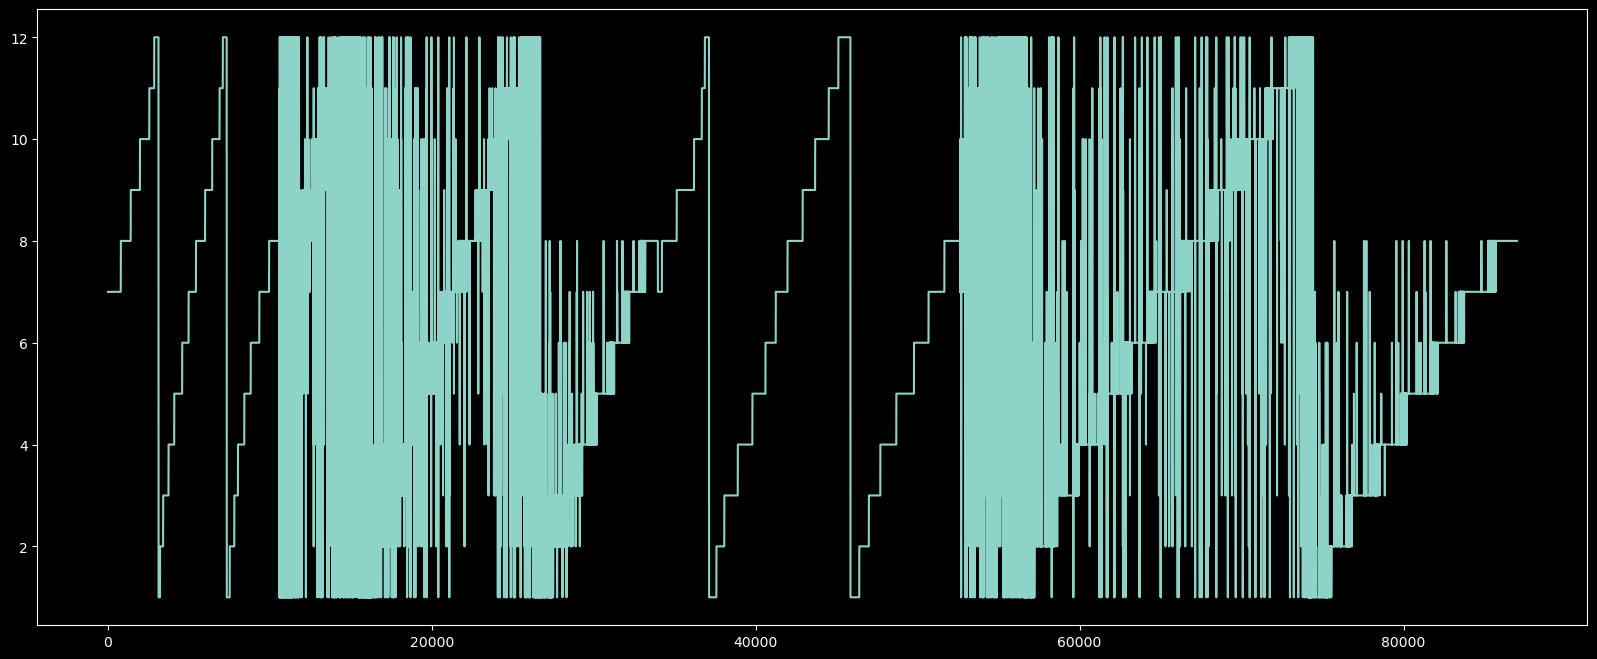

In [36]:
plt.figure(figsize=(20,8))
df['arrival_date_month'].plot()

There is indeed cyclical patterns in the dataset, let's transform the date features.

In [37]:
# define a function for trig transformation
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [38]:
# apply function
df = encode(df, 'arrival_date_month', 12)
df = encode(df, 'arrival_date_day_of_month', 31)

# drop original columns
df = df.drop(columns=['arrival_date_month','arrival_date_day_of_month'])

Let's look at the transformed columns.

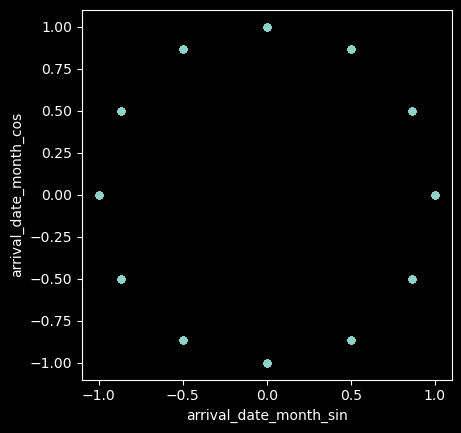

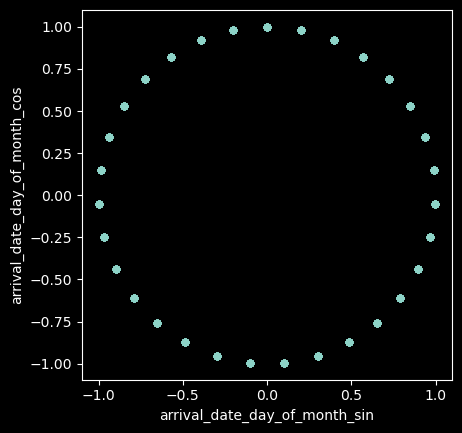

In [39]:
ax = df.plot.scatter('arrival_date_month_sin', 'arrival_date_month_cos').set_aspect('equal')

ax = df.plot.scatter('arrival_date_day_of_month_sin', 'arrival_date_day_of_month_cos').set_aspect('equal')

Now, the month December would follow right after January, the time difference would just be 1 month. As well as January 1st would follow after December 31st, the difference would be 1 day.

In [40]:
df[['arrival_date_month_sin','arrival_date_month_cos','arrival_date_day_of_month_sin','arrival_date_day_of_month_cos']].describe()

,arrival_date_month_sin,arrival_date_month_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos
count,8.700900e+04,87009.000000,8.700900e+04,87009.000000
mean,-4.371033e-02,-0.152342,-9.959151e-04,-0.014052
std,7.192698e-01,0.676420,7.088353e-01,0.705242
min,-1.000000e+00,-1.000000,-9.987165e-01,-0.994869
25%,-8.660254e-01,-0.866025,-7.247928e-01,-0.758758
50%,-2.449294e-16,-0.500000,-2.449294e-16,-0.050649
75%,5.000000e-01,0.500000,7.247928e-01,0.688967
max,1.000000e+00,1.000000,9.987165e-01,1.000000


Now, these four trig-transformed columns are of range -1 to 1. This is suitable scale for my dataset. There is no need to apply scaler on these featrues, for it will break the cylical patterns that were just perserved.

## Distribution Channel

In [41]:
df['distribution_channel'].value_counts()

TA/TO        68841
Direct       12920
Corporate     5062
GDS            181
Undefined        5
Name: distribution_channel, dtype: int64

In [42]:
df[df['distribution_channel']=='Undefined']

,hotel,is_canceled,lead_time,arrival_date_year,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_stays,special_requests,arrival_date_month_sin,arrival_date_month_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos
11373,Resort Hotel,0,103,2015,2,1,HB,PRT,Direct,Undefined,0,No,0,A,A,0,No Deposit,No agent,0,0,Transient,112.7,1,5,1,-0.500000,-0.866025,0.848644,0.528964
34227,City Hotel,1,2,2015,2,0,BB,PRT,Undefined,Undefined,0,No,0,B,B,0,No Deposit,No agent,0,0,Transient-Party,12.0,0,1,1,-0.866025,-0.500000,0.571268,0.820763
34260,City Hotel,1,1,2015,2,0,BB,PRT,Direct,Undefined,0,No,0,B,B,0,No Deposit,14,0,0,Transient-Party,12.0,0,2,1,-0.866025,-0.500000,0.848644,0.528964
34264,City Hotel,1,1,2015,3,0,BB,PRT,Undefined,Undefined,0,No,0,B,B,0,No Deposit,No agent,0,0,Transient-Party,18.0,0,2,1,-0.866025,-0.500000,0.848644,0.528964
34567,City Hotel,1,8,2015,2,0,BB,PRT,Online TA,Undefined,0,No,0,B,B,0,No Deposit,9,0,0,Transient-Party,76.5,0,7,1,-0.866025,-0.500000,0.485302,-0.874347


I will drop this distribution channel in one-hot encoding.

# Encoding

Now, I am using One-hot Encoder to encode the rest categorical features. We have already defined some least frequent categories we should drop instead. Let's get a list of all of them.

In [43]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_stays,special_requests,arrival_date_month_sin,arrival_date_month_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos
0,Resort Hotel,0,342,2015,2,0,BB,PRT,Direct,Direct,0,No,0,C,C,3,No Deposit,No agent,0,0,Transient,0.0,0,0,0,-0.5,-0.866025,0.201299,0.97953
1,Resort Hotel,0,737,2015,2,0,BB,PRT,Direct,Direct,0,No,0,C,C,4,No Deposit,No agent,0,0,Transient,0.0,0,0,0,-0.5,-0.866025,0.201299,0.97953
2,Resort Hotel,0,7,2015,1,0,BB,GBR,Direct,Direct,0,No,0,A,C,0,No Deposit,No agent,0,0,Transient,75.0,0,1,0,-0.5,-0.866025,0.201299,0.97953
3,Resort Hotel,0,13,2015,1,0,BB,GBR,Corporate,Corporate,0,No,0,A,A,0,No Deposit,Other,0,0,Transient,75.0,0,1,0,-0.5,-0.866025,0.201299,0.97953
4,Resort Hotel,0,14,2015,2,0,BB,GBR,Online TA,TA/TO,0,No,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,2,1,-0.5,-0.866025,0.201299,0.97953


In [44]:
# get all the least frequent categories

cat = ['hotel','arrival_date_year','market_segment','deposit_type','customer_type','distribution_channel','agent','country','meal','previous_cancellations','reserved_room_type','assigned_room_type']
drop_list = []

for i in cat:
    
    category_counts = df[i].value_counts()
    
    # identify the least frequent category
    least_frequent_category = category_counts.idxmin()
    
    drop_list.append(least_frequent_category)
    
print(drop_list)

['Resort Hotel', 2015, 'Undefined', 'Refundable', 'Group', 'Undefined', 243, 'ROU', 'FB', 'High', 'L', 'L']


In [45]:
# add prefixes to the names of each category
drop_list = ['hotel_Resort Hotel', 'arrival_date_year_2015', 'market_segment_Undefined', 'deposit_type_Refundable', 'customer_type_Group', 'distribution_channel_Undefined', 'agent_243', 'country_ROU', 'meal_FB', 'previous_cancellations_High', 'reserved_room_type_L', 'assigned_room_type_L']

In [46]:
# one-hot encoding
for i in cat:
    
    dummies = pd.get_dummies(df[i], prefix=i,)
    df = pd.concat([df,dummies],axis=1)

In [47]:
# complete list of columns to drop
final_list = ['hotel','arrival_date_year','market_segment','deposit_type','customer_type','distribution_channel','agent','country','meal','previous_cancellations','reserved_room_type','assigned_room_type','hotel_Resort Hotel', 'arrival_date_year_2015', 'market_segment_Undefined', 'deposit_type_Refundable', 'customer_type_Group', 'distribution_channel_Undefined', 'agent_243', 'country_ROU', 'meal_FB', 'previous_cancellations_High', 'reserved_room_type_L', 'assigned_room_type_L']

# drop least frequent categories and original columns
df = df.drop(columns=final_list)

In [48]:
df.head()

,is_canceled,lead_time,adults,children,is_repeated_guest,previous_bookings_not_canceled,booking_changes,company,days_in_waiting_list,adr,required_car_parking_spaces,total_stays,special_requests,arrival_date_month_sin,arrival_date_month_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,hotel_City Hotel,arrival_date_year_2016,arrival_date_year_2017,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,agent_1,agent_6,agent_7,agent_8,agent_9,agent_14,agent_28,agent_40,agent_83,agent_85,agent_240,agent_241,agent_242,agent_250,agent_314,agent_No agent,agent_Other,country_AUT,country_BEL,country_BRA,country_CHE,country_CHN,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_NOR,country_Other,country_POL,country_PRT,country_RUS,country_SWE,country_USA,meal_BB,meal_HB,meal_SC,previous_cancellations_Low,previous_cancellations_Medium,previous_cancellations_No,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K
0,0,342,2,0,0,0,3,0,0,0.0,0,0,0,-0.5,-0.866025,0.201299,0.97953,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,737,2,0,0,0,4,0,0,0.0,0,0,0,-0.5,-0.866025,0.201299,0.97953,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,7,1,0,0,0,0,0,0,75.0,0,1,0,-0.5,-0.866025,0.201299,0.97953,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,13,1,0,0,0,0,0,0,75.0,0,1,0,-0.5,-0.866025,0.201299,0.97953,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,14,2,0,0,0,0,0,0,98.0,0,2,1,-0.5,-0.866025,0.201299,0.97953,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Transformation

In [49]:
# check variances of all the numeric features
df.var()

is_canceled                          0.199375
lead_time                         7397.319828
adults                               0.378610
children                             0.214202
is_repeated_guest                    0.031070
previous_bookings_not_canceled       3.010903
booking_changes                      0.504507
company                              0.056547
days_in_waiting_list               100.272651
adr                               2693.504403
required_car_parking_spaces          0.076899
total_stays                          7.533043
special_requests                     0.249997
arrival_date_month_sin               0.517349
arrival_date_month_cos               0.457543
arrival_date_day_of_month_sin        0.502447
arrival_date_day_of_month_cos        0.497366
hotel_City Hotel                     0.237957
arrival_date_year_2016               0.249767
arrival_date_year_2017               0.231198
market_segment_Aviation              0.002591
market_segment_Complementary      

All these features have pretty high variances, and columns are in different scale. The dataset needs to be normalized. I will apply scaler to the dataset after train-test split, as the training data needs to be scaled based on the values in the training set alone, and be completely independent of the validation and test sets. After that, validation and test sets are scaled based on the parameters used to scale the training set to avoid any data leakage.

# Class Imbalance

One last thing, we need to check for any class imbalance in the dataset.

In [50]:
# check for any imbalance in our target variabel
round(df['is_canceled'].value_counts(normalize=True)*100,2)

0    72.5
1    27.5
Name: is_canceled, dtype: float64

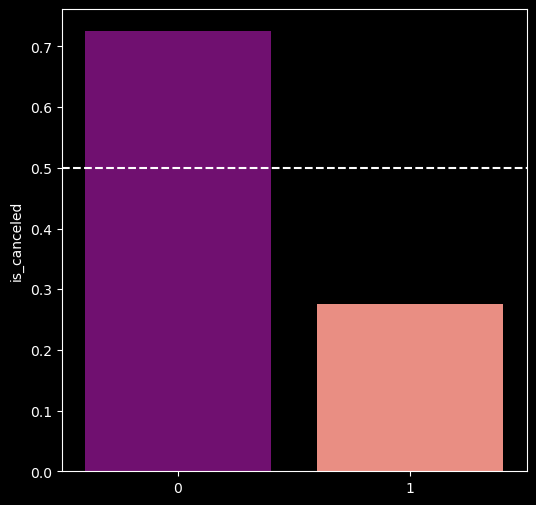

In [51]:
plt.figure(figsize=(6,6))
sns.barplot(x=df['is_canceled'].value_counts().index,
            y=df['is_canceled'].value_counts(normalize=True),
            palette=['purple','salmon'])
plt.axhline(0.5,color='white',linestyle='--')
plt.show()

73% of non-canceled bookings and 27% of canceled bookings, this imbalance is quite significant. I will deal with this imbalance in the next notebook during modelling step.

# Export Preprocessed Dataset

In [52]:
df.shape

(87009, 96)

The shape of the final cleaned and preprocessed dataframe has 87009 data points and 96 features in total.

In [53]:
# export
df.to_csv('hotel_preprocessed.csv',index=False)